In [151]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
key = '5e6bbd0e3991e4888a436338a938fd961cd835ca'

ModuleNotFoundError: No module named 'pandas_datareader'

In [ ]:
df = pdr.get_data_tiingo('AMZN',api_key=key)

In [ ]:
df['date'] = pd.to_datetime(df['date']).dt.date
df.head()
df.to_csv('AMZN.csv')

In [152]:
df=pd.read_csv('AMZN.csv', usecols = ['date','close'], parse_dates=['date'], index_col=0)
df.head()

,close
date,
2017-02-10 00:00:00+00:00,827.46
2017-02-13 00:00:00+00:00,836.53
2017-02-14 00:00:00+00:00,836.39
2017-02-15 00:00:00+00:00,842.70
2017-02-16 00:00:00+00:00,844.14


In [153]:
df.shape

(1258, 1)

In [154]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(df.values)

In [155]:
print(df1.shape)

(1258, 1)


In [156]:
# Splitting data into train and test
training_size = int(len(df1)*0.70)
test_size = len(df1)-training_size
train_data = df1[0:training_size,:]
test_data = df1[training_size:len(df1),:1]

In [157]:
#Converting array to matrix dataset
def create_dataset(dataset,time_step=1):
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        temp = dataset[i:(i+time_step),0]
        dataX.append(temp)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)
        

In [158]:
time_step = 150
X_train,Y_train = create_dataset(train_data,time_step)
X_test,Y_test = create_dataset(test_data,time_step)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(729, 150) (729,) (227, 150) (227,)


In [159]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [160]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [161]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [162]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 150, 50)           10400     
_________________________________________________________________
lstm_22 (LSTM)               (None, 150, 50)           20200     
_________________________________________________________________
lstm_23 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


Epoch 1/150
2/2 [==============================] - 6s 2s/step - loss: 0.1110 - val_loss: 0.4470
Epoch 2/150
2/2 [==============================] - 2s 1s/step - loss: 0.0577 - val_loss: 0.1867
Epoch 3/150
2/2 [==============================] - 3s 1s/step - loss: 0.0150 - val_loss: 0.0063
Epoch 4/150
2/2 [==============================] - 3s 1s/step - loss: 0.0146 - val_loss: 0.0056
Epoch 5/150
2/2 [==============================] - 3s 1s/step - loss: 0.0181 - val_loss: 0.0172
Epoch 6/150
2/2 [==============================] - 3s 1s/step - loss: 0.0054 - val_loss: 0.0751
Epoch 7/150
2/2 [==============================] - 3s 1s/step - loss: 0.0072 - val_loss: 0.1162
Epoch 8/150
2/2 [==============================] - 3s 1s/step - loss: 0.0105 - val_loss: 0.1141
Epoch 9/150
2/2 [==============================] - 3s 1s/step - loss: 0.0097 - val_loss: 0.0828
Epoch 10/150
2/2 [==============================] - 3s 1s/step - loss: 0.0062 - val_loss: 0.0448
Epoch 11/150
2/2 [=====================

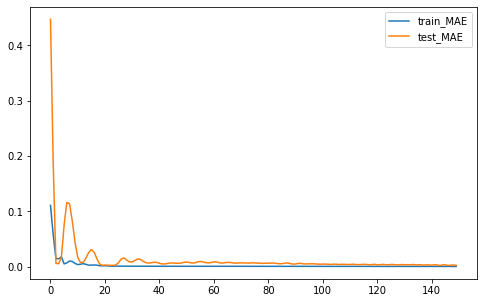

In [163]:
history = model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=150,batch_size=450,verbose=1)
# plot history
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train_MAE')
plt.plot(history.history['val_loss'], label='test_MAE')
plt.legend()
plt.show()

In [164]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [165]:
import math
from statistics import mean
from sklearn.metrics import mean_squared_error
train_rmse = math.sqrt(mean_squared_error(Y_train,train_predict))
test_rmse = math.sqrt(mean_squared_error(Y_test,test_predict))
print('Train RMSE: %.3f' % train_rmse)
print('Test RMSE: %.3f' % test_rmse)

Train RMSE: 0.027
Test RMSE: 0.050


In [166]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

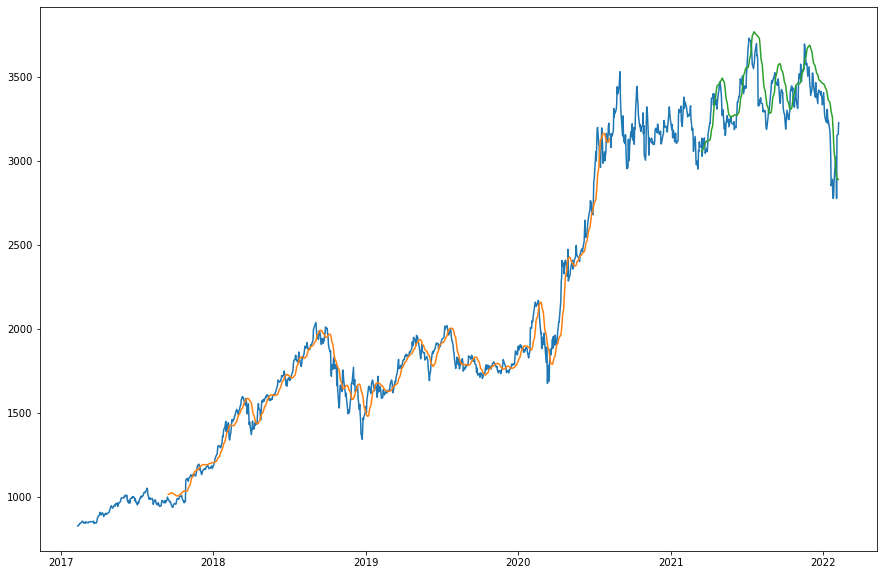

In [167]:
# Plotting original data csv
plt.figure(figsize=(15,10))
plt.plot(df.index, df['close'].values)
plt.plot(df.index[time_step:len(train_predict)+time_step], train_predict)
plt.plot(df.index[len(train_predict)+(time_step*2)+1:len(df1)-1], test_predict)

plt.show()